In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
module_path = Path("..").resolve().as_posix()
if module_path not in sys.path:
    print(f"Adding {module_path} to python path")
    sys.path.append(module_path)

Adding /home/rav/projects/gwas-analysis/notebooks/platform/xarray to python path


In [3]:
import lib.io.pysnptools_backend

In [34]:
from lib import api
import pandas as pd
import numpy as np
from dask_ml.decomposition import PCA
import dask
import dask.array as da
import seaborn as sns
import time

In [5]:
# This data was generated via hail using Balding-Nichols model: samples=1000, variants=5000, populations=3
path = Path(f"{Path.home()}/projects/tmp/plink_s_1000_v_5000_p_3/data").as_posix()

ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
g = ds.data.data
g

dask.array<filled, shape=(5000, 1000), dtype=int8, chunksize=(5000, 1000), chunktype=numpy.ndarray>

In [6]:
pca = PCA(n_components=8, random_state=42)
pca.fit(g)

PCA(copy=True, iterated_power=0, n_components=8, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

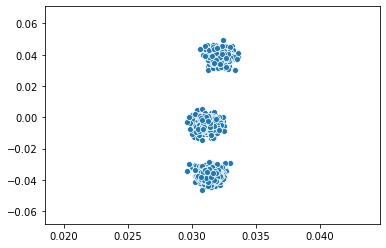

In [7]:
sns.scatterplot(x=pca.components_[0], y=pca.components_[1])

In [8]:
pcs = da.from_array(pca.components_)
pcs = pcs[:2,:]
pcs

dask.array<getitem, shape=(2, 1000), dtype=float64, chunksize=(2, 1000), chunktype=numpy.ndarray>

## PC-Relate building blocks

In [9]:
pcsi = da.concatenate([da.from_array(np.ones((1, pcs.shape[1]))), pcs], axis=0).rechunk()
pcsi

dask.array<rechunk-merge, shape=(3, 1000), dtype=float64, chunksize=(3, 1000), chunktype=numpy.ndarray>

In [10]:
# This is reduced form
q, r = da.linalg.qr(pcsi.T)

In [11]:
# mu, eq: 3
half_beta = da.matmul(da.matmul(da.linalg.inv(2 * r), q.T), g.T)
mu = da.matmul(pcsi.T, half_beta).T
mu

dask.array<transpose, shape=(5000, 1000), dtype=float64, chunksize=(5000, 1000), chunktype=numpy.ndarray>

In [12]:
variance = mu.map_blocks(lambda i: np.clip(i, 0.0, 1.0, i)).map_blocks(lambda i: i * (1.0 - i))
variance

dask.array<lambda, shape=(5000, 1000), dtype=float64, chunksize=(5000, 1000), chunktype=numpy.ndarray>

In [13]:
stddev = da.sqrt(variance)
stddev.compute()

array([[0.47993923, 0.47614381, 0.49818271, ..., 0.47366131, 0.49719972,
        0.47006002],
       [0.42964806, 0.41437403, 0.49424793, ..., 0.40229698, 0.48834645,
        0.38514072],
       [0.49981768, 0.49993941, 0.49362756, ..., 0.49990494, 0.48970379,
        0.49991222],
       ...,
       [0.25567743, 0.2305759 , 0.36484629, ..., 0.20074722, 0.32366383,
        0.15869643],
       [0.4101674 , 0.40591151, 0.41210763, ..., 0.39454982, 0.36345057,
        0.38305604],
       [0.45809329, 0.46335225, 0.36863723, ..., 0.46231907, 0.32957991,
        0.46323701]])

In [14]:
def center(g, mu):
    #return 0.0 if not mu else g / 2 - mu
    return g / 2 - mu
centered_af = da.blockwise(center, "ij", g, "ij", mu, "ij")
centered_af.compute()

array([[-0.1402082 ,  0.34739899, -0.04259097, ..., -0.16014045,
        -0.05284352,  0.32957824],
       [ 0.24426078,  0.22018906, -0.57562394, ..., -0.29691268,
        -0.10732076, -0.31885204],
       [-0.01350119, -0.00778401,  0.42042716, ..., -0.50974966,
        -0.10094649,  0.49063115],
       ...,
       [-0.07031517, -0.05633937, -0.15811232, ..., -0.04206927,
        -0.11889407, -0.02585293],
       [ 0.28594179,  0.29195179, -0.21686169, ...,  0.80713261,
        -0.15662894, -0.1786465 ],
       [-0.70037598,  0.31210458,  0.16220333, ..., -0.19042341,
        -0.37600144,  0.31182063]])

In [15]:
# phi, eq: 4
def gramian(a):
    return da.dot(a.T, a)

phi = gramian(centered_af) / gramian(stddev)
phi.compute()

array([[ 0.51003418,  0.01758208, -0.02494998, ...,  0.0109461 ,
         0.01618898,  0.01113273],
       [ 0.01758208,  0.51128395, -0.01450236, ...,  0.01732672,
         0.00065847,  0.00989644],
       [-0.02494998, -0.01450236,  0.4961406 , ..., -0.00595362,
        -0.01042235,  0.01112394],
       ...,
       [ 0.0109461 ,  0.01732672, -0.00595362, ...,  0.50973499,
        -0.00570222,  0.00475032],
       [ 0.01618898,  0.00065847, -0.01042235, ..., -0.00570222,
         0.49518496,  0.0046317 ],
       [ 0.01113273,  0.00989644,  0.01112394, ...,  0.00475032,
         0.0046317 ,  0.49732644]])

## Complete 1st iteration PC-Relate

In [48]:
from lib.method.pc_relate.pc_relate import pc_relate

In [51]:
phi = pc_relate(pcs, g)
phi

dask.array<truediv, shape=(1000, 1000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

## Compare to GENESIS's PC-Relate

In [18]:
genesis_kinship = pd.read_csv("kinbtwe.csv")
genesis_kinship = genesis_kinship[["ID1","ID2", "kin"]]
# R counts from 1
genesis_kinship["ID1"] = genesis_kinship.ID1 - 1
genesis_kinship["ID2"] = genesis_kinship.ID2 - 1
genesis_kinship.kin.nlargest(3)

256572    0.035780
428358    0.034111
414036    0.033744
Name: kin, dtype: float64

In [19]:
#genesis_kinship.set_index(["ID1", "ID2"], inplace=True)
indices = (genesis_kinship["ID1"] * 1000 + genesis_kinship["ID2"]).to_numpy()
values = genesis_kinship["kin"].to_numpy()
assert len(indices) == len(values), "len(indices) must equal len(values)"
genesis_kinship_full = np.zeros((1000, 1000))
np.put(genesis_kinship_full, indices, values)
assert len(genesis_kinship_full[genesis_kinship_full != 0.0]) == 499500, "genesis_kinship_full should have 499500 non 0.0 elements"
genesis_kinship_full

array([[ 0.        ,  0.00369688, -0.0015866 , ...,  0.00133513,
         0.00444841,  0.00913023],
       [ 0.        ,  0.        ,  0.00219561, ...,  0.01220922,
        -0.00718352,  0.01041031],
       [ 0.        ,  0.        ,  0.        , ...,  0.00379945,
         0.00044219,  0.01457223],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01022723,  0.00408978],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00415541],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
phi_diag_0 = da.triu(phi, k=1).compute() # zero above main diagonal
np.max(phi_diag_0)

0.1852351745402649

In [21]:
assert len(phi_diag_0[phi_diag_0 != 0.0]) == 499500, "phi_diag_0 should have 499500 non 0.0 elements"

In [22]:
np.allclose(phi_diag_0, genesis_kinship_full, atol=0.17512, rtol=0.0)

True

## Use PCs from GENESIS's PC-AiR

In [23]:
f = pd.read_csv("pcs_from_pc_air.csv", usecols=[1,2])
f

,V1,V2
0,0.051327,0.005714
1,0.048592,0.006531
2,-0.035021,0.038964
3,-0.021209,-0.050307
4,-0.034078,0.041609
...,...,...
995,-0.018637,-0.048012
996,-0.021234,-0.046038
997,0.048352,0.004725
998,-0.019719,-0.045904


In [24]:
pcs_air = da.from_array(f.to_numpy()).T
phi_air = pc_relate(pcs_air, g)
phi_air

dask.array<truediv, shape=(1000, 1000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [25]:
phi_air_diag_0 = da.triu(phi_air, k=1).compute() # zero above main diagonal
np.max(phi_air_diag_0)

0.03563241143463957

In [26]:
np.allclose(phi_air_diag_0, genesis_kinship_full, atol=0.004847, rtol=0.0)

True

## HapMap YRI r23a

In [27]:
# wget http://zzz.bwh.harvard.edu/plink/dist/hapmap_YRI_r23a.zip
path = Path(f"{Path.home()}/projects/tmp/yri_r23/hapmap_YRI_r23a").as_posix()
yri_r23 = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
g_yri_r23 = yri_r23.data.data
g_yri_r23

dask.array<filled, shape=(3880150, 90), dtype=int8, chunksize=(776030, 90), chunktype=numpy.ndarray>

In [28]:
pca_yri_r23 = PCA(n_components=4, random_state=42)
pca_yri_r23.fit(g_yri_r23)

PCA(copy=True, iterated_power=0, n_components=4, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

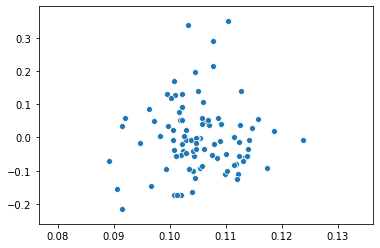

In [29]:
sns.scatterplot(x=pca_yri_r23.components_[0], y=pca_yri_r23.components_[1])

In [30]:
pcs_yri_r23 = da.from_array(pca_yri_r23.components_)
pcs_yri_r23 = pcs_yri_r23[:2,:]
pcs_yri_r23

dask.array<getitem, shape=(2, 90), dtype=float64, chunksize=(2, 90), chunktype=numpy.ndarray>

In [40]:
phi_yri_r23 = pc_relate(pcs_yri_r23, g_yri_r23)
t_0 = time.time()
phi_yri_r23_diag_0 = da.triu(phi_yri_r23, k=1).compute()
print(f"HapMap YRI PC-Relate took: {time.time() - t_0:.2f} sec")

# R GENESIS times:
# KING kinship: 12.431 sec elapsed
# PC-AIR: 42.385 sec elapsed
# PC-Relate: 737.594 sec elapsed

HapMap YRI PC-Relate took: 9.18 sec


In [41]:
phi_yri_r23_diag_0[0] #sample: NA18500 in Family: Yoruba_004, NA18501 NA18502 is father and mother

array([ 0.00000000e+00,  2.50381911e-01,  2.43514917e-01, -1.98976020e-02,
       -1.53182437e-02, -1.29861473e-02, -1.85621360e-02, -1.68155312e-02,
       -1.59426028e-02,  3.98047860e-03, -3.01675907e-04,  8.30866298e-05,
       -1.18493935e-02, -1.47029860e-02, -7.23033075e-03, -1.32638373e-02,
       -1.01172081e-02, -1.99207035e-02, -2.11833081e-02, -2.02529024e-02,
       -2.21996695e-02, -2.70661604e-03, -1.76056881e-02, -1.15278016e-02,
       -1.42459813e-02, -3.00950420e-02, -2.21941926e-02, -2.32024657e-02,
       -3.48478702e-03, -1.51608577e-02, -1.46535007e-02, -2.45478553e-02,
       -2.30125479e-02, -1.46911840e-02, -1.56274902e-02, -1.66760611e-02,
       -2.75402363e-03, -6.86727434e-03, -4.37411549e-03, -1.08194482e-02,
       -1.06223178e-03, -3.04521882e-03, -1.57282918e-02, -5.84741287e-03,
       -1.53547779e-02, -1.04392387e-02, -1.18676144e-02, -1.67889540e-02,
       -5.09214915e-03, -2.38744819e-02, -1.81446086e-02,  1.09975098e-03,
       -2.00640789e-02, -

In [42]:
yri_r23

<xarray.Dataset>
Dimensions:     (sample: 90, variant: 3880150)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 3880146 3880147 3880148 3880149
  * sample      (sample) int64 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(776030, 90), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(776030, 90), meta=np.ndarray>
    sample_id   (sample) object dask.array<chunksize=(90,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(90,), meta=np.ndarray>
    pat_id      (sample) object dask.array<chunksize=(90,), meta=np.ndarray>
    mat_id      (sample) object dask.array<chunksize=(90,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(90,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(90,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(2312549,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(2312549,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(2312549,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(2312549,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(2312549,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(2312549,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

In [43]:
yri_r23.sel(sample=0).compute()

<xarray.Dataset>
Dimensions:     (variant: 3880150)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 3880146 3880147 3880148 3880149
    sample      int64 0
Data variables:
    data        (variant) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    is_masked   (variant) bool False False False False ... False False False
    sample_id   <U10 'Yoruba_004'
    fam_id      <U7 'NA18500'
    pat_id      <U7 'NA18501'
    mat_id      <U7 'NA18502'
    is_female   int64 1
    phenotype   int64 0
    contig      (variant) int64 1 1 1 1 1 1 1 1 1 ... 26 26 26 26 26 26 26 26 26
    variant_id  (variant) object 'rs10399749' 'rs2949421' ... 'rs2854125'
    cm_pos      (variant) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    pos         (variant) int64 45162 45413 46844 72434 ... 15929 16141 16149
    a1          (variant) object '0' 'A' '0' '0' '0' '0' ... 'G' '0' '0' '0' 'T'
    a2          (variant) object 'C' 'T' 'C' 'G' 'C' 'A' ... 'A' 'A' 'G' 'T' 'C'
Attributes:
    type:     GenotypeCountDataset

## Duplicate sample

In [44]:
g_dup = da.concatenate([g, g[:, 0].reshape(5000,1)], axis=1).rechunk()
print(da.all(g_dup[:,0] == g_dup[:,-1]).compute())

True


In [45]:
pca_dup = PCA(n_components=8, random_state=42)
pca_dup.fit(g_dup)
pcs_dup = da.from_array(pca_dup.components_)
pcs_dup = pcs_dup[:2,:]
pcs_dup

dask.array<getitem, shape=(2, 1001), dtype=float64, chunksize=(2, 1001), chunktype=numpy.ndarray>

In [46]:
phi_dup = pc_relate(pcs_dup, g_dup)
phi_dup

dask.array<truediv, shape=(1001, 1001), dtype=float64, chunksize=(1001, 1001), chunktype=numpy.ndarray>

In [47]:
phi_dup[0, 1000].compute()

0.5019160941287695